In [1]:
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense, Flatten, LSTM, Conv1D, MaxPooling1D, Dropout, Activation
from keras.layers.embeddings import Embedding

import plotly.offline as py
import plotly.graph_objs as go
py.init_notebook_mode(connected=True)

import nltk
import string
import numpy as np
import pandas as pd
from nltk.corpus import stopwords

from sklearn.manifold import TSNE

import re
import string
from nltk.stem.wordnet import WordNetLemmatizer

In [3]:
df = pd.read_csv('new_yelp.csv', index_col=0, low_memory=False)

In [4]:
df = df[~df.isna().any(axis=1)]

In [5]:
def clean_text(text):
    text = text.translate(string.punctuation)
    text = text.lower().split()
    stops = set(stopwords.words('english'))
    text = [word for word in text if (word not in stops) & (len(word) > 3)]
    text = ' '.join(text)
    
    #Cleaning
    text = re.sub(r"[^A-Za-z0-9^,!.\/'+-=]", " ", text)
    text = re.sub(r"what's", "what is ", text)
    text = re.sub(r"\'s", " ", text)
    text = re.sub(r"\'ve", " have ", text)
    text = re.sub(r"n't", " not ", text)
    text = re.sub(r"i'm", "i am ", text)
    text = re.sub(r"\'re", " are ", text)
    text = re.sub(r"\'d", " would ", text)
    text = re.sub(r"\'ll", " will ", text)
    text = re.sub(r",", " ", text)
    text = re.sub(r"\.", " ", text)
    text = re.sub(r"!", " ! ", text)
    text = re.sub(r"\/", " ", text)
    text = re.sub(r"\^", " ^ ", text)
    text = re.sub(r"\+", " + ", text)
    text = re.sub(r"\-", " - ", text)
    text = re.sub(r"\=", " = ", text)
    text = re.sub(r"'", " ", text)
    text = re.sub(r"(\d+)(k)", r"\g<1>000", text)
    text = re.sub(r":", " : ", text)
    text = re.sub(r" e g ", " eg ", text)
    text = re.sub(r" b g ", " bg ", text)
    text = re.sub(r" u s ", " american ", text)
    text = re.sub(r"\0s", "0", text)
    text = re.sub(r" 9 11 ", "911", text)
    text = re.sub(r"e - mail", "email", text)
    text = re.sub(r"j k", "jk", text)
    text = re.sub(r"\s{2,}", " ", text)
    text = re.sub(r"cannot", "can not", text)
    text = re.sub(r"gotta", "got to", text)
    text = re.sub(r"gonna", "going to", text)
    text = re.sub(r"wanna", "want to", text)
    text = re.sub(r"gimme", "give me", text)
    text = re.sub(r"lemme", "let me", text)
    
    text = text.split()
    lemmatizer = WordNetLemmatizer()
    lemmas = [lemmatizer.lemmatize(word) for word in text]
    text = ' '.join(lemmas)
    
    return text

In [6]:
df['text'] = df['text'].apply(lambda x: clean_text(x))

In [7]:
#tokenizing
from nltk import word_tokenize
df['tokenized'] = df['text'].apply(lambda t: word_tokenize(t))

In [8]:
#training word vectors
from gensim.models import Word2Vec
model_w2v = Word2Vec(df['tokenized'], size=100)

In [9]:
#indexing reviews
from keras.preprocessing.text import Tokenizer
from collections import OrderedDict

voc_size = 20000
tokenizer = Tokenizer(num_words=voc_size)
tokenizer.fit_on_texts(df['text'])
tokens = OrderedDict(sorted(tokenizer.word_index.items(), key=lambda t: t[1]))

In [10]:
emb_matrix = np.zeros((voc_size, 100))

for word, index in tokens.items():
    if index > (voc_size-1):
        break
    else:
        if word in model_w2v.wv:
            emb_vec = model_w2v.wv[word]
            emb_matrix[index] = emb_vec

In [12]:
from keras.preprocessing.sequence import pad_sequences

seqs = tokenizer.texts_to_sequences(df['text'])
data = pad_sequences(seqs, maxlen=50)

In [14]:
%%time
model = Sequential()
model.add(Embedding(voc_size, 100, input_length=50,
                   weights=[emb_matrix], trainable=True))
model.add(Dropout(.2))
model.add(Conv1D(64, 5, activation='relu'))
model.add(MaxPooling1D(pool_size=4))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(loss='binary_crossentropy', optimizer='adam', 
             metrics=['accuracy'])
model.fit(data, df['labels'], validation_split=.4, epochs=3)

Train on 1041810 samples, validate on 694540 samples
Epoch 1/3
1041810/1041810 [==============================] - 2426s 2ms/step - loss: 0.2904 - acc: 0.8749 - val_loss: 0.2730 - val_acc: 0.8849
Epoch 2/3
1041810/1041810 [==============================] - 2366s 2ms/step - loss: 0.2708 - acc: 0.8848 - val_loss: 0.2681 - val_acc: 0.8870
Epoch 3/3
1041810/1041810 [==============================] - 33541s 32ms/step - loss: 0.2638 - acc: 0.8881 - val_loss: 0.2657 - val_acc: 0.8874
Wall time: 10h 38min 56s


In [15]:
word_embs = model.layers[0].get_weights()[0]

In [27]:
%%time
X_embedded = umap.UMAP(n_neighbors=5,
                      min_dist=0.3,
                      metric='cosine').fit_transform(word_embs)

Wall time: 18.9 s


In [28]:
word_list = []
for word, i in tokens.items():
    word_list.append(word)

In [29]:
number_of_words = 1000
trace = go.Scatter(
    x=X_embedded[0:number_of_words,0], 
    y=X_embedded[0:number_of_words, 1],
    mode='markers',
    text=word_list[0:number_of_words]
)
layout = dict(title='t-SNE 1 vs t-SNE 2 for first 1000 words ',
              yaxis=dict(title='t-SNE 2'),
              xaxis=dict(title='t-SNE 1'),
              hovermode='closest')
fig = dict(data=[trace], layout=layout)
py.iplot(fig)

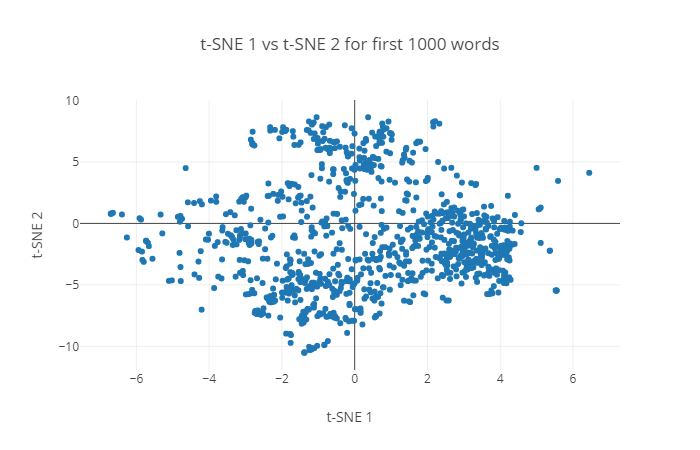

In [30]:
from IPython.display import Image
Image(filename='newplot4.png')